In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/COMP7416/Assignment1')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install specific libraries
! pip install transformers
! pip install pycaret
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
# specify GPU
device = torch.device('cuda:0')

In [4]:
import random
import numpy as np

random.seed(2024)
np.random.seed(2024)
torch.manual_seed(2024)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(2024)

## Prepare Dataset

### Read Dataset

In [5]:
fake_df = pd.read_csv("./Fake.csv")
true_df = pd.read_csv("./True.csv")

In [6]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [8]:
fake_df.describe()

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [9]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [10]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [11]:
true_df.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


### EDA

In [12]:
def plotbh(df, col):
    '''Draw boxplot and histogram for numerical variables'''
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    # Boxplot
    sns.boxplot(x=df[col], ax=axs[0])
    axs[0].set_title('Box chart of ' + col)

    # Histogram
    sns.histplot(data=df, x=col, kde=True, ax=axs[1])
    axs[1].set_title('Histogram of ' + col)

    plt.tight_layout()
    plt.show()

In [13]:
fake_df['word_count'] = fake_df['text'].apply(lambda x : len(x.split()))
fake_df['word_count'].describe()

,word_count
count,23481.000000
mean,423.197905
std,408.388890
min,0.000000
25%,240.000000
50%,363.000000
75%,506.000000
max,8135.000000


In [14]:
fake_df_empty_strings_count = fake_df[fake_df['word_count'] == 0].shape[0]
fake_df_empty_strings_count

630

In [15]:
# Delete innocent text rows
fake_df = fake_df[fake_df['word_count'] > 0].reset_index(drop=True)

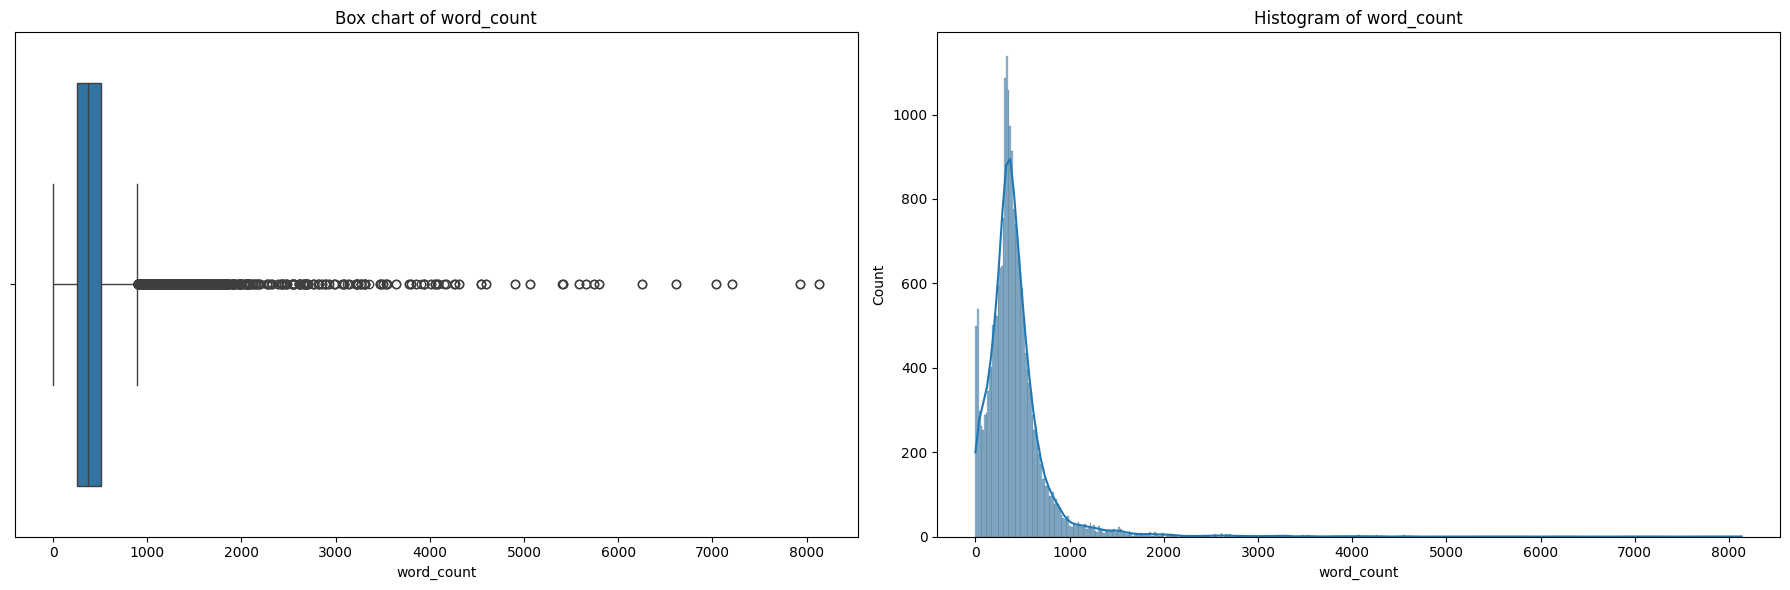

In [16]:
plotbh(fake_df, 'word_count')

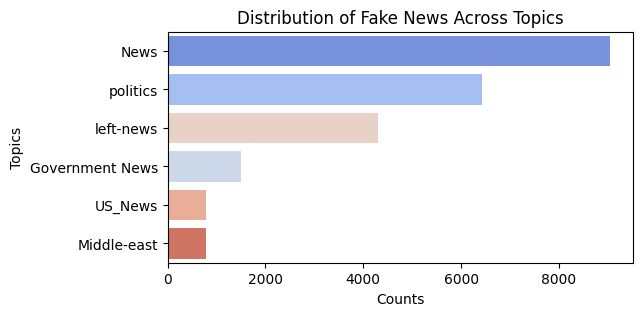

In [17]:
topics = fake_df['subject'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(6, 3))
sns.countplot(y='subject', data=fake_df, order=topics.index,
              hue=fake_df['subject'], palette="coolwarm")
plt.title('Distribution of Fake News Across Topics')
plt.xlabel('Counts')
plt.ylabel('Topics')
plt.show()

In [18]:
true_df['word_count'] = true_df['text'].apply(lambda x : len(x.split()))
true_df['word_count'].describe()

,word_count
count,21417.000000
mean,385.640099
std,274.006204
min,0.000000
25%,148.000000
50%,359.000000
75%,525.000000
max,5172.000000


In [19]:
true_df_empty_strings_count = true_df[true_df['word_count'] == 0].shape[0]
true_df_empty_strings_count

1

In [20]:
true_df = true_df[true_df['word_count'] > 0].reset_index(drop=True)

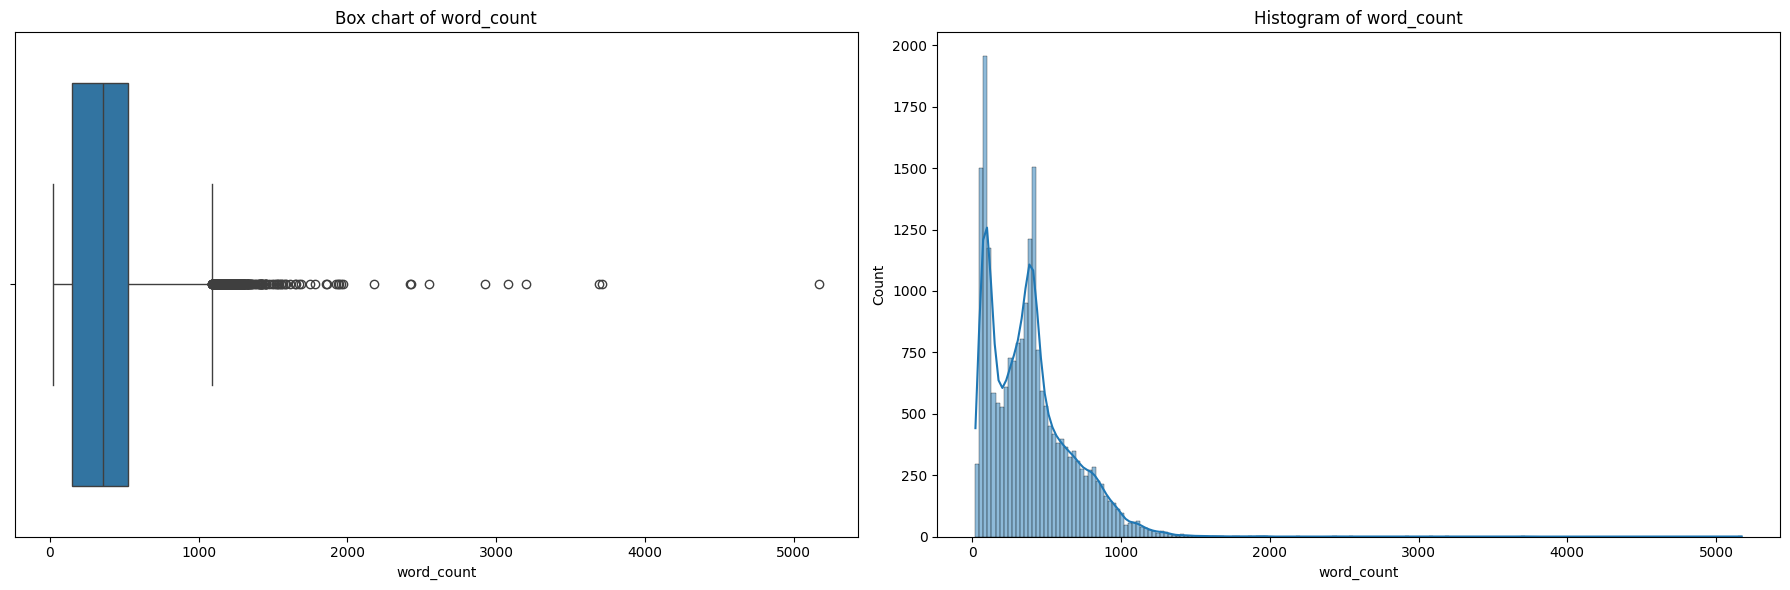

In [21]:
plotbh(true_df, 'word_count')

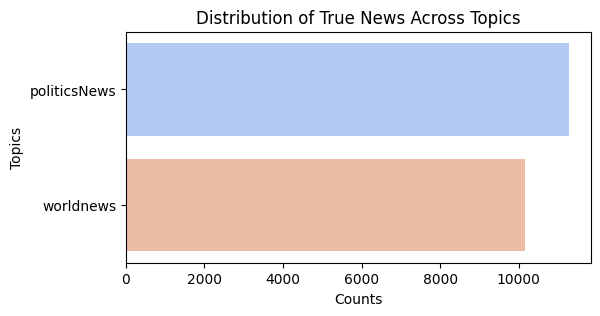

In [22]:
topics = true_df['subject'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(6, 3))
sns.countplot(y='subject', data=true_df, order=topics.index,
              hue=true_df['subject'], palette="coolwarm")
plt.title('Distribution of True News Across Topics')
plt.xlabel('Counts')
plt.ylabel('Topics')
plt.show()

## Pre-process Data

### Concatenate Fake and True as single Data Source

In [23]:
# Allocate label
fake_df['Target'] = 'fake'
true_df['Target'] = 'true'

In [24]:
# concate them together and mix in random
news_df = pd.concat([fake_df, true_df]).sample(frac=1).reset_index(drop=True)
print(news_df.shape)
news_df.head()

(44267, 6)


,title,text,subject,date,word_count,Target
0,MAN MAKES VIRAL VIDEO: Demonstrates How Obama ...,"(function(d, s, id) { var js, fjs = d.getElem...",politics,"Jan 13, 2016",199,fake
1,TWITTER CLAIMS They’re Cracking Down On “Hate ...,"Earlier today, it was revealed that the US Sec...",politics,"Aug 17, 2017",419,fake
2,Trump Might Not Propose A Budget Next Year In...,"In an unprecedented move, the Trump administra...",News,"December 4, 2016",371,fake
3,MARINE ARRESTED FOR Complaining About Governme...,This is some pretty surreal stuff In the four ...,left-news,"Nov 27, 2015",139,fake
4,Italy's Renzi defends referendum,WASHINGTON (Reuters) - Italian Prime Minister ...,politicsNews,"October 18, 2016",80,true


In [25]:
news_df['label'] = news_df['Target'].apply(lambda x: 1 if x == 'fake' else 0)
news_df.head()

,title,text,subject,date,word_count,Target,label
0,MAN MAKES VIRAL VIDEO: Demonstrates How Obama ...,"(function(d, s, id) { var js, fjs = d.getElem...",politics,"Jan 13, 2016",199,fake,1
1,TWITTER CLAIMS They’re Cracking Down On “Hate ...,"Earlier today, it was revealed that the US Sec...",politics,"Aug 17, 2017",419,fake,1
2,Trump Might Not Propose A Budget Next Year In...,"In an unprecedented move, the Trump administra...",News,"December 4, 2016",371,fake,1
3,MARINE ARRESTED FOR Complaining About Governme...,This is some pretty surreal stuff In the four ...,left-news,"Nov 27, 2015",139,fake,1
4,Italy's Renzi defends referendum,WASHINGTON (Reuters) - Italian Prime Minister ...,politicsNews,"October 18, 2016",80,true,0


([<matplotlib.patches.Wedge at 0x7836928760b0>,
 [Text(-1.1984446032400655, -0.061078089072615, 'fake'),
  Text(1.1984446032400653, 0.061078089072615395, 'true')],
 [Text(-0.6990926852233714, -0.03562888529235875, '51.6%'),
  Text(0.6990926852233714, 0.035628885292358976, '48.4%')])

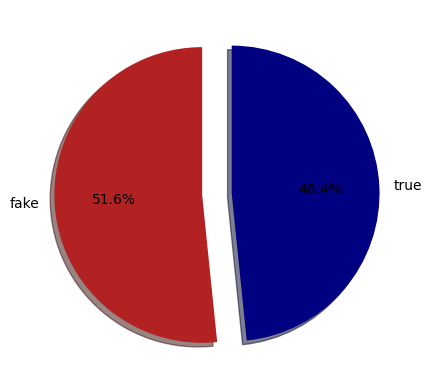

In [26]:
# Checking if our data is well balanced
label_size = [news_df['label'].sum(),len(news_df['label'])-news_df['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['fake','true'],autopct='%1.1f%%')

## Training Model

### Train-Test Split

In [27]:
# Train-Validation-Test set split into 0.7, 0.15 and 0.15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(news_df['title'], news_df['label'],
                                                                    test_size=0.3,
                                                                    stratify=news_df['Target'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

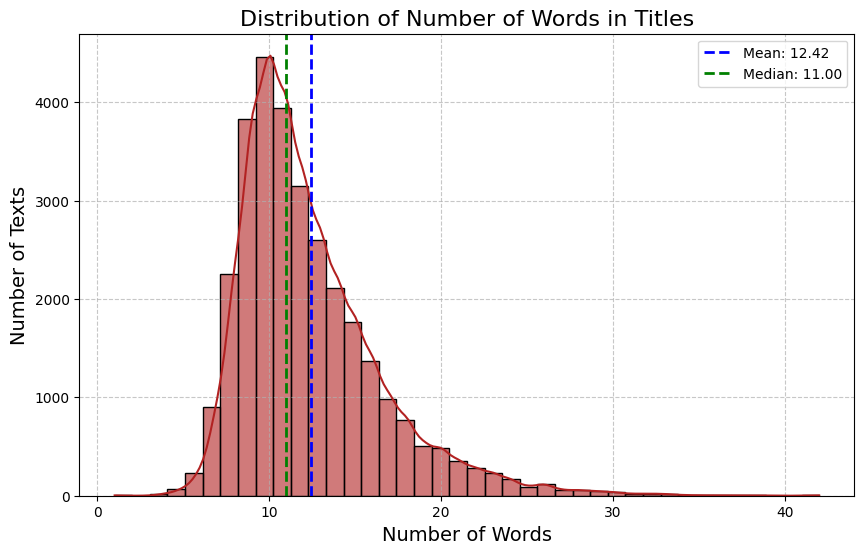

In [28]:
# Calculate the sequence lengths
seq_len = [len(title.split()) for title in train_text]

# Create the histogram
plt.figure(figsize=(10, 6))  # Increase figure size for better readability
sns.histplot(seq_len, bins=40, kde=True, color='firebrick', alpha=0.6)  # Add KDE for smooth distribution

# Add mean and median lines
mean_len = sum(seq_len) / len(seq_len)
median_len = pd.Series(seq_len).median()

plt.axvline(mean_len, color='blue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_len:.2f}')
plt.axvline(median_len, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_len:.2f}')

# Add titles and labels
plt.title('Distribution of Number of Words in Titles', fontsize=16)
plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Number of Texts', fontsize=14)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show legend
plt.legend()

# Display the plot
plt.show()


## Bert Fine-tuning

In [29]:
# Load the Bert
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [30]:
# Majority of titles above have word length under 13. So, we set max title length as 13
MAX_LENGHT = 13
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    padding=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    padding=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    padding=True,
    truncation=True
)

In [31]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [32]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

### Freeze Layer

In [33]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return the current device index, usually 0
print(torch.cuda.get_device_name(0))  # Should return the name of the GPU

True
0
Tesla T4


In [34]:
# Move BERT to device
bert.to(device)

for param in bert.parameters():
    param.requires_grad = False  # Freeze BERT parameters

### Define Model Architecture

In [35]:
class BERT_Arch(torch.nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = torch.nn.Dropout(0.1)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(768, 512)
        self.fc2 = torch.nn.Linear(512, 2)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Instantiate and move the model to the device
model = BERT_Arch(bert).to(device)


In [36]:
# Verify if the model is on the correct device
model.to(device)
for param in model.parameters():
    if param.device.type != device.type or param.device.index != device.index:
      print(f"Mismatch: param.device={param.device}, device={device}")
    else:
      print(f"Match: param.device={param.device}, device={device}")

Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device=cuda:0
Match: param.device=cuda:0, device

In [37]:
# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
cross_entropy = torch.nn.CrossEntropyLoss()

# Number of training epochs
epochs = 2

### Define Train & Evaluate Function

In [38]:
# Training function
def train():
    model.train()
    total_loss, total_accuracy = 0, 0

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print(f'  Batch {step:>5,}  of  {len(train_dataloader):>5,}.')

        # Move batch data to device
        sent_id, mask, labels = [r.to(device) for r in batch]
        labels = labels.long()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    # Compute the average loss
    avg_loss = total_loss / len(train_dataloader)
    return avg_loss

# Evaluation function
def evaluate():
    print("\nEvaluating...")
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for step, batch in enumerate(val_dataloader):
            if step % 50 == 0 and not step == 0:
                print(f'  Batch {step:>5,}  of  {len(val_dataloader):>5,}.')

            # Move batch data to device
            sent_id, mask, labels = [r.to(device) for r in batch]
            labels = labels.long()

            # Forward pass
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

    # Compute the average loss
    avg_loss = total_loss / len(val_dataloader)
    return avg_loss


### Model Training

In [39]:
# Train and predict
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    # train model
    train_loss = train()
    # evaluate model
    valid_loss = evaluate()
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_news_model_weights.pt') # save the best model
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    969.
  Batch   100  of    969.
  Batch   150  of    969.
  Batch   200  of    969.
  Batch   250  of    969.
  Batch   300  of    969.
  Batch   350  of    969.
  Batch   400  of    969.
  Batch   450  of    969.
  Batch   500  of    969.
  Batch   550  of    969.
  Batch   600  of    969.
  Batch   650  of    969.
  Batch   700  of    969.
  Batch   750  of    969.
  Batch   800  of    969.
  Batch   850  of    969.
  Batch   900  of    969.
  Batch   950  of    969.

Evaluating...
  Batch    50  of    208.
  Batch   100  of    208.
  Batch   150  of    208.
  Batch   200  of    208.

Training Loss: 0.582
Validation Loss: 0.507

 Epoch 2 / 2
  Batch    50  of    969.
  Batch   100  of    969.
  Batch   150  of    969.
  Batch   200  of    969.
  Batch   250  of    969.
  Batch   300  of    969.
  Batch   350  of    969.
  Batch   400  of    969.
  Batch   450  of    969.
  Batch   500  of    969.
  Batch   550  of    969.
  Batch   600  of    969.
  

### Model Performance

In [ ]:
path = 'best_news_model_weights.pt'
model.load_state_dict(torch.load(path))

In [ ]:
# Move the model to the appropriate device
model.to(device)

# Ensure the tensors are also on the same device
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)

In [ ]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

### Fake News Predictions

In [ ]:
# testing on unseen data
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers"                          # True
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])


In [ ]:
model.to(device)
unseen_seq = unseen_seq.to(device)
unseen_mask = unseen_mask.to(device)

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds